In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential,Model, Input
from keras.layers.convolutional import Conv2D,Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SeparableConv2D , DepthwiseConv2D, concatenate,Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras import backend as k

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


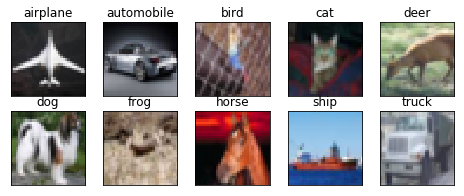

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)

In [0]:
Input_ = Input(shape=(32, 32, 3))

#Layer1 5x5 Separable , Depthwise
x1 = SeparableConv2D(16, (5, 5),padding='same')(Input_)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = Dropout(0.2)(x1)

#Layer2 Normal Conv2d 5x5
x2 = Conv2D(32, (5, 5),padding='same')(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Dropout(0.2)(x2)

#Layer3 Normal Conv2d 5x5
x3 = Conv2D(32, (5, 5),padding='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)

x3 = Dropout(0.2)(x3)

x3_concat = concatenate([x3,x1])

#Layer4 5x5 Separable
x4 = SeparableConv2D(32, (5, 5),padding='same')(x3_concat)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)

x4 = Dropout(0.2)(x4)
#Layer5 Maxpool
x5 = MaxPooling2D((2,2))(concatenate([x4,x1]))

#Bottleneck 1x1 to reduce params
x5 = Conv2D(16, (1, 1), activation='relu')(x5)


#Layer6 3x3 Separable , Depthwise
x6 = SeparableConv2D(32, (3, 3),padding='same')(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)

x6 = Dropout(0.2)(x6)

x6_concat = concatenate([x6, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4)])

#Layer7 Normal Conv2d 5x5
x7 = Conv2D(32, (5, 5),padding='same')(x6_concat)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)

x7 = Dropout(0.2)(x7)

x7_concat = concatenate([x7, Lambda(space_to_depth_x2)(x3),Lambda(space_to_depth_x2)(x4), x6])

#Layer8 3x3 Separable , Depthwise
x8 = SeparableConv2D(32, (3, 3),padding='same')(x7_concat)
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)

x8 = Dropout(0.2)(x8)

x8_concat = concatenate([x8, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x3), Lambda(space_to_depth_x2)(x4), x6, x7])

#Layer9 5x5 Separable Depthwise.
x9 = SeparableConv2D(64, (5, 5),padding='same')(x8_concat)
x9 = BatchNormalization()(x9)
x9 = Activation('relu')(x9)

x9 = Dropout(0.2)(x9)

x9_concat = concatenate([x9, Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4), x6, x8x])

#Layer10 Maxpool
x10 = MaxPooling2D((2,2))(x9_concat)

#Bottleneck 1x1 to reduce params
x10 = Conv2D(64, (1, 1), activation='relu')(x10)

x10_concat = concatenate([x10, Lambda(space_to_depth_x2)(x7)])

#Layer11 Normal Conv2d 5x5
x11 = Conv2D(64, (5, 5),padding='same')(x10_concat)
x11 = BatchNormalization()(x11)
x11 = Activation('relu')(x11)

x11 = Dropout(0.2)(x11)

x11_concat = concatenate([x11,Lambda(space_to_depth_x4)(x1),Lambda(space_to_depth_x4)(x2),Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x8)])

#Layer12 5x5 Separable , Depthwise
x12 = SeparableConv2D(64, (5, 5),padding='same')(x11_concat)
x12 = BatchNormalization()(x12)
x12 = Activation('relu')(x12)

x12 = Dropout(0.2)(x12)

x12_concat = concatenate([x12,Lambda(space_to_depth_x4)(x2),Lambda(space_to_depth_x4)(x3),MaxPooling2D((2,2))(x6),x11])

#Layer13 Normal Conv2d 3x3
x13 = Conv2D(64, (3, 3),padding='same')(x12_concat)
x13 = BatchNormalization()(x13)
x13 = Activation('relu')(x13)

x13 = Dropout(0.2)(x13)

x13_concat = concatenate([x13,Lambda(space_to_depth_x4)(x1),Lambda(space_to_depth_x4)(x3),Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x6),Lambda(space_to_depth_x2)(x8),x12])

#Layer14 5x5 Separable , Depthwise
x14 = SeparableConv2D(128, (5, 5),padding='same')(x13_concat)
x14 = BatchNormalization()(x14)
x14 = Activation('relu')(x14)

x14 = Dropout(0.2)(x14)

x15_concat = concatenate([x14,Lambda(space_to_depth_x4)(x4),Lambda(space_to_depth_x2)(x8),x12])

# 1x1 to reduce channels
x16 = Conv2D(10, (1, 1), activation='relu')(x15_concat)
x16 = AveragePooling2D(8,8)(x16)
x16=  Flatten()(x16)
output = Activation(activation='softmax')(x16)

model = Model(Input_, output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, 32, 32, 16)   139         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 32, 32, 16)   64          separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 32, 32, 16)   0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
dropout_42

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0710 10:53:53.724193 139740649027456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 105s 268ms/step - loss: 1.3657 - acc: 0.5032 - val_loss: 1.7215 - val_acc: 0.5023
Epoch 2/100
390/390 [==============================] - 95s 244ms/step - loss: 0.9532 - acc: 0.6613 - val_loss: 1.0944 - val_acc: 0.6212
Epoch 3/100
390/390 [==============================] - 94s 242ms/step - loss: 0.7941 - acc: 0.7193 - val_loss: 0.9809 - val_acc: 0.6626
Epoch 4/100
390/390 [==============================] - 94s 242ms/step - loss: 0.6995 - acc: 0.7543 - val_loss: 0.8361 - val_acc: 0.7102
Epoch 5/100
390/390 [==============================] - 94s 242ms/step - loss: 0.6249 - acc: 0.7812 - val_loss: 0.8663 - val_acc: 0.6947
Epoch 6/100
390/390 [==============================] - 94s 242ms/step - loss: 0.5692 - acc: 0.8009 - val_loss: 1.0595 - val_acc: 0.6623
Epoch 7/100
390/390 [==============================] - 94s 242ms/step - loss: 0.5158 - acc: 0.8182 - val_loss: 1.2250 - val_acc: 0.6297
Epoch 8/100
390/390 [==========================

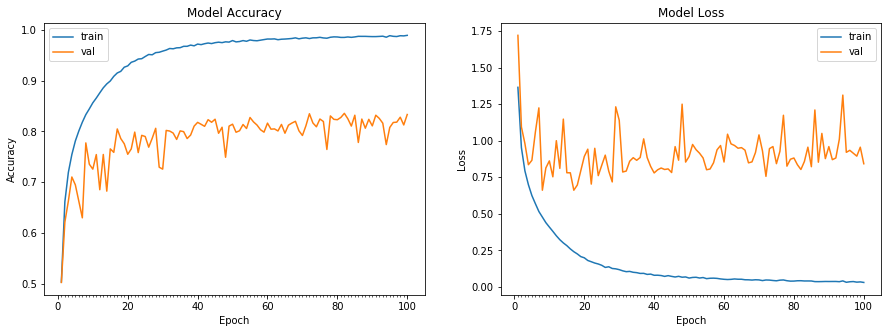

Accuracy on test data is: 83.33


In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Final accuracy : 83.33